In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('D:/Wisdom/workspace_python/research')
sys.path=list(set(sys.path))

import keras
from keras import backend as K
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, Dropout)
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data

from model import keras_models
from model.keras_models import create_dense_layers, inst_layers
from module_DTI.utils import plot_mse_mae_history, plot_roc_curve, plot_epoch_acc_loss

In [59]:
mnist=input_data.read_data_sets("../dataset/MNIST_data/",one_hot=False)
print(mnist.train.num_examples)
print(mnist.validation.num_examples)
print(mnist.test.num_examples)

Extracting ../dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../dataset/MNIST_data/t10k-labels-idx1-ubyte.gz
55000
5000
10000


In [60]:
pixel=28
image_size=pixel*pixel
n_class=10

In [61]:
x_train,y_train=mnist.train.next_batch(55000)
x_val,y_val=mnist.validation.next_batch(5000)
x_test,y_test=mnist.test.next_batch(10000)

y_train,y_val,y_test=to_categorical(y_train),to_categorical(y_val),to_categorical(y_test)
# x=(x-np.min(x,axis=0))/(np.max(x,axis=0)-np.min(x,axis=0))
# y=target
# y=to_categorical(target)
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=1)
x_train.shape

(55000, 784)

## Define and Train Autoencoder

In [51]:
Inputs=Input(shape=(image_size,))
latent_dim=32

AE=keras_models.AutoEncoder(Inputs,latent_dim=latent_dim)
AE.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['mse','mae']) 
h_AE=AE.fit(x_train,x_train,batch_size=256,epochs=30,validation_data=(x_val,x_val),callbacks=[EarlyStopping()])

Train on 60000 samples, validate on 5000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 93us/step - loss: 0.2755 - mean_squared_error: 0.0692 - mean_absolute_error: 0.1658 - val_loss: 0.1879 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1029
Epoch 2/30
60000/60000 [==============================] - 4s 71us/step - loss: 0.1704 - mean_squared_error: 0.0344 - mean_absolute_error: 0.0904 - val_loss: 0.1529 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.0787
Epoch 3/30
60000/60000 [==============================] - 4s 74us/step - loss: 0.1438 - mean_squared_error: 0.0257 - mean_absolute_error: 0.0718 - val_loss: 0.1335 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.0647
Epoch 4/30
60000/60000 [==============================] - 5s 78us/step - loss: 0.1287 - mean_squared_error: 0.0209 - mean_absolute_error: 0.0611 - val_loss: 0.1218 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0563
Epoch 5/30
60000/60000 [===

#### check autoencoder mse graph

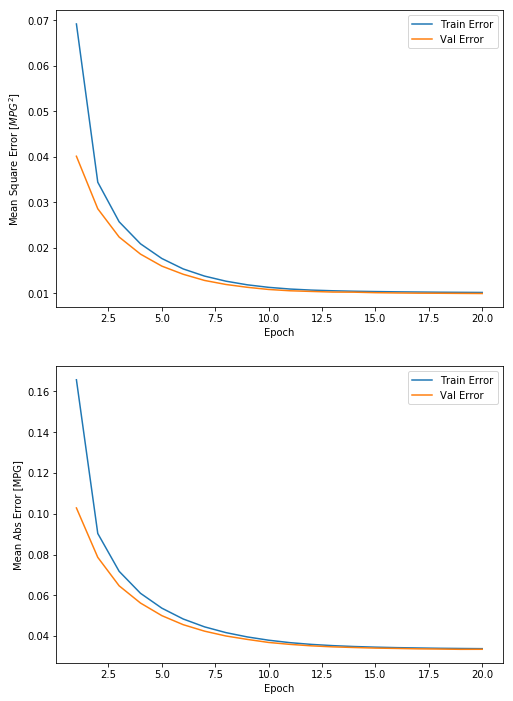

In [52]:
plot_mse_mae_history(h_AE)

#### check autoencoder reconstruction images

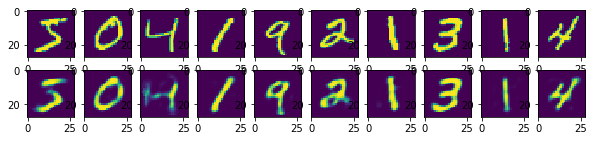

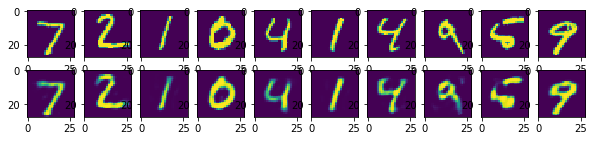

In [53]:
x_reconstructed=AE.predict(x_train[0:10])
x_reconstructed2=AE.predict(x_test[0:10])
f,a=plt.subplots(2,10,figsize=(10,2))
for i in range(10):
    a[0][i].imshow(np.reshape(x_train[i],(pixel,pixel)))
    a[1][i].imshow(np.reshape(x_reconstructed[i],(pixel,pixel)))
f,a2=plt.subplots(2,10,figsize=(10,2))
for i in range(10):
    a2[0][i].imshow(np.reshape(x_test[i],(pixel,pixel)))
    a2[1][i].imshow(np.reshape(x_reconstructed2[i],(pixel,pixel)))
f.show()
plt.show()

## Define classifier

In [63]:
LR=keras_models.LogisticRegression(inputs=Inputs,n_class=10)
MLP=keras_models.MultiLayerPerceptron(inputs=Inputs,n_class=10)
LR.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
MLP.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])


In [64]:
z_Inputs=Input(shape=(latent_dim,))
AE_MLP=keras_models.MultiLayerPerceptron(inputs=z_Inputs,n_class=10)
AE_MLP.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

## Training phase

In [65]:
h_LR=LR.fit(x_train,y_train,batch_size=100,epochs=15,validation_data=(x_val,y_val))
h_MLP=MLP.fit(x_train,y_train,batch_size=100,epochs=15,validation_data=(x_val,y_val))


Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 4s 68us/step - loss: 0.6341 - acc: 0.8437 - val_loss: 0.3652 - val_acc: 0.9082
Epoch 2/15
55000/55000 [==============================] - 2s 45us/step - loss: 0.3526 - acc: 0.9041 - val_loss: 0.3074 - val_acc: 0.9156
Epoch 3/15
55000/55000 [==============================] - 3s 51us/step - loss: 0.3147 - acc: 0.9124 - val_loss: 0.2855 - val_acc: 0.9198
Epoch 4/15
55000/55000 [==============================] - 3s 49us/step - loss: 0.2965 - acc: 0.9171 - val_loss: 0.2771 - val_acc: 0.9232
Epoch 5/15
55000/55000 [==============================] - 2s 40us/step - loss: 0.2856 - acc: 0.9203 - val_loss: 0.2696 - val_acc: 0.9252
Epoch 6/15
55000/55000 [==============================] - 2s 44us/step - loss: 0.2779 - acc: 0.9224 - val_loss: 0.2661 - val_acc: 0.9248
Epoch 7/15
55000/55000 [==============================] - 2s 41us/step - loss: 0.2726 - acc: 0.9239 - val_loss: 0.2621 - val_acc:

#### latent feature representation through trained autoencoder

In [66]:
ae_x_train=AE.encoder.predict(x_train)
ae_x_val=AE.encoder.predict(x_val)
ae_x_test=AE.encoder.predict(x_test)

#### training phase of MLP inputting latent features

In [67]:
h_AE_MLP=AE_MLP.fit(ae_x_train,y_train,batch_size=100,epochs=15,validation_data=(ae_x_val,y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 10s 176us/step - loss: 0.5075 - acc: 0.8454 - val_loss: 0.1967 - val_acc: 0.9406
Epoch 2/15
55000/55000 [==============================] - 10s 183us/step - loss: 0.2491 - acc: 0.9246 - val_loss: 0.1717 - val_acc: 0.9472
Epoch 3/15
55000/55000 [==============================] - 8s 147us/step - loss: 0.1988 - acc: 0.9390 - val_loss: 0.1120 - val_acc: 0.9694
Epoch 4/15
55000/55000 [==============================] - 9s 155us/step - loss: 0.1717 - acc: 0.9473 - val_loss: 0.1131 - val_acc: 0.9662
Epoch 5/15
55000/55000 [==============================] - 7s 136us/step - loss: 0.1535 - acc: 0.9525 - val_loss: 0.1059 - val_acc: 0.9686
Epoch 6/15
55000/55000 [==============================] - 10s 183us/step - loss: 0.1442 - acc: 0.9556 - val_loss: 0.0898 - val_acc: 0.9732
Epoch 7/15
55000/55000 [==============================] - 10s 186us/step - loss: 0.1348 - acc: 0.9581 - val_loss: 0.0903

## comparison

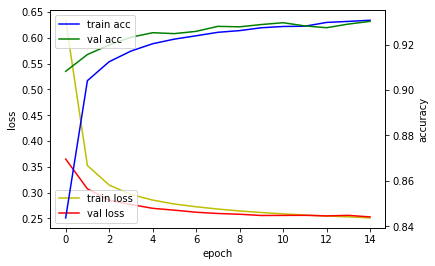

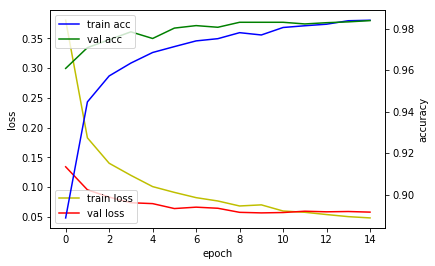

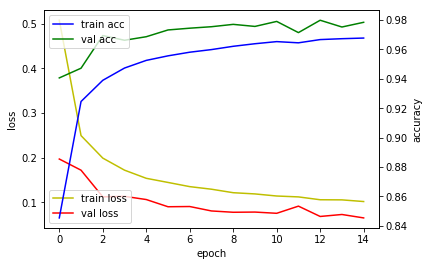

In [68]:
plot_epoch_acc_loss(h_LR)
plot_epoch_acc_loss(h_MLP)
plot_epoch_acc_loss(h_AE_MLP)

In [70]:
print(LR.evaluate(x_train,y_train))
print(LR.evaluate(x_test,y_test))
print(MLP.evaluate(x_train,y_train))
print(MLP.evaluate(x_test,y_test))
print(AE_MLP.evaluate(ae_x_train,y_train))
print(AE_MLP.evaluate(ae_x_test,y_test))

55000/55000 [==============================] - 3s 46us/step
[0.2466217128948732, 0.9319636363723062]
10000/10000 [==============================] - 0s 47us/step
[0.26437222987413406, 0.9267]
55000/55000 [==============================] - 6s 115us/step
[0.009685031678910706, 0.9975818181818182]
10000/10000 [==============================] - 1s 111us/step
[0.05833471900606528, 0.983]
55000/55000 [==============================] - 6s 106us/step
[0.05008462222655388, 0.9844909090909091]
10000/10000 [==============================] - 1s 103us/step
[0.06981125519201159, 0.9781]
